## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_log_error

from xgboost import XGBRegressor

## Preprocessing & Data Info

The dataset is taken from Kaggle:
https://www.kaggle.com/c/nyc-taxi-trip-duration/data


     

Data fields:

1- id: a unique identifier for each trip    
2- vendor_id: a code indicating the provider associated with the trip record    
3- pickup_datetime: date and time when the meter was engaged    
4- dropoff_datetime: date and time when the meter was disengaged    
5- passenger_count: the number of passengers in the vehicle (driver entered value)  
6- pickup_longitude: the longitude where the meter was engaged  
7- pickup_latitude: the latitude where the meter was engaged    
8- dropoff_longitude: the longitude where the meter was disengaged  
9- dropoff_latitude: the latitude where the meter was disengaged    
10- store_and_fwd_flag:‌ This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip   
11- trip_duration: duration of the trip in seconds  

In [3]:
train_dataset_path = "Data/train.csv"

df = pd.read_csv(train_dataset_path)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
# no null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N':0, 'Y':1})

In [9]:
# time engineering

""" df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
df['pickup_day'] = pd.to_datetime(df['pickup_datetime']).dt.day_of_week
df['pickup_month'] = pd.to_datetime(df['pickup_datetime']).dt.month """

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day_of_week
df['pickup_month'] = df['pickup_datetime'].dt.month

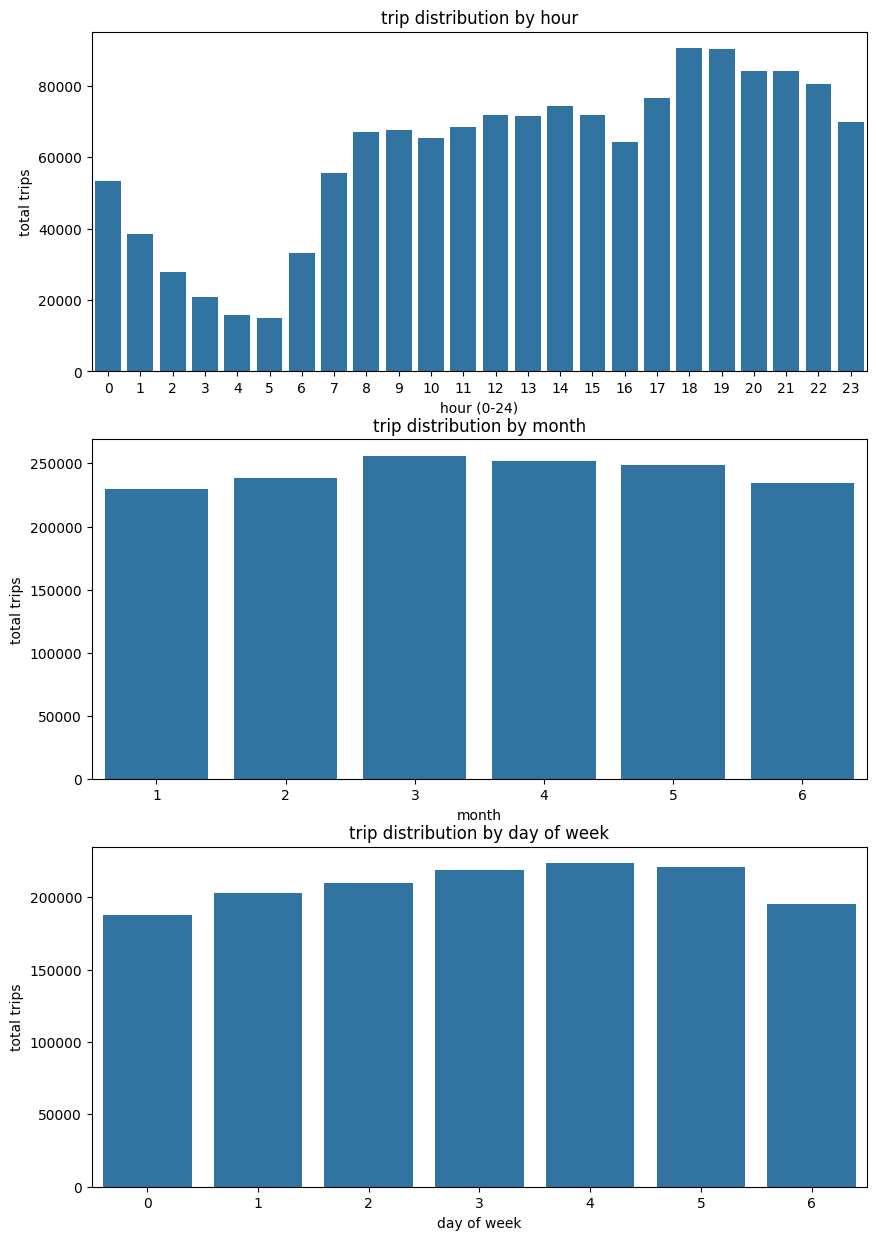

In [10]:
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
sns.countplot(x=df['pickup_hour'])
plt.title("trip distribution by hour")
plt.xlabel('hour (0-24)')
plt.ylabel('total trips')


plt.subplot(3, 1, 2)
sns.countplot(x=df['pickup_month'])
plt.title("trip distribution by month")
plt.xlabel('month')
plt.ylabel('total trips')


plt.subplot(3, 1, 3)
sns.countplot(x=df['pickup_day'])
plt.title("trip distribution by day of week")
plt.xlabel('day of week')
plt.ylabel('total trips')


plt.show()

## Pickup & Dropoff Outliers

In [11]:
# new york lat and long coordinates:
# min long: -74.05, max long: -73.70
# min lat: 40.50, max lat: 40.95

pick_outlier = (~df['pickup_latitude'].between(40.50, 40.95)) | \
                (~df['pickup_longitude'].between(-74.05, -73.70))

drop_outlier = (~df['dropoff_latitude'].between(40.50, 40.95)) | \
                (~df['dropoff_longitude'].between(-74.05, -73.70))

location_outliers = pick_outlier | drop_outlier

print(f"total outliers in pickup locations: {pick_outlier.sum()}")
print(f"total outliers in drop off locations: {drop_outlier.sum()}")

total outliers in pickup locations: 651
total outliers in drop off locations: 4675


In [12]:
# making a distance column from lat and long
lat1, long1 = df['pickup_latitude'], df['pickup_longitude']
lat2, long2 = df['dropoff_latitude'], df['dropoff_longitude']


lat1_rad, long1_rad, lat2_rad, long2_rad = np.radians([lat1, long1, lat2, long2])


# haversite formula (distance on sphere)
a = np.power(np.sin((lat2_rad - lat1_rad) / 2), 2) + \
    np.cos(lat1_rad) * np.cos(lat2_rad) * np.power(np.sin((long2_rad - long1_rad) / 2), 2)

df['distance'] = 2 * 6371 * np.arcsin(np.sqrt(a))

In [13]:
for percentile in range(0, 11):
    perc = df['distance'].quantile(percentile/100)
    print(f"{percentile} percentile: {perc:.2f} KM")

0 percentile: 0.00 KM
1 percentile: 0.14 KM
2 percentile: 0.37 KM
3 percentile: 0.47 KM
4 percentile: 0.54 KM
5 percentile: 0.60 KM
6 percentile: 0.64 KM
7 percentile: 0.68 KM
8 percentile: 0.72 KM
9 percentile: 0.76 KM
10 percentile: 0.79 KM


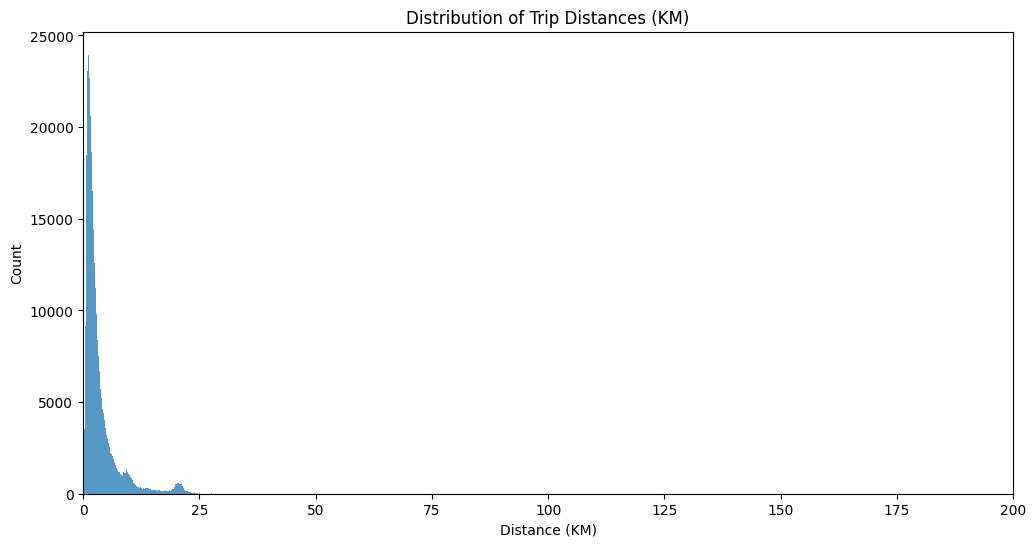

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df['distance'])
plt.title('Distribution of Trip Distances (KM)')
plt.xlabel('Distance (KM)')
plt.xlim(0, 200)
plt.show()

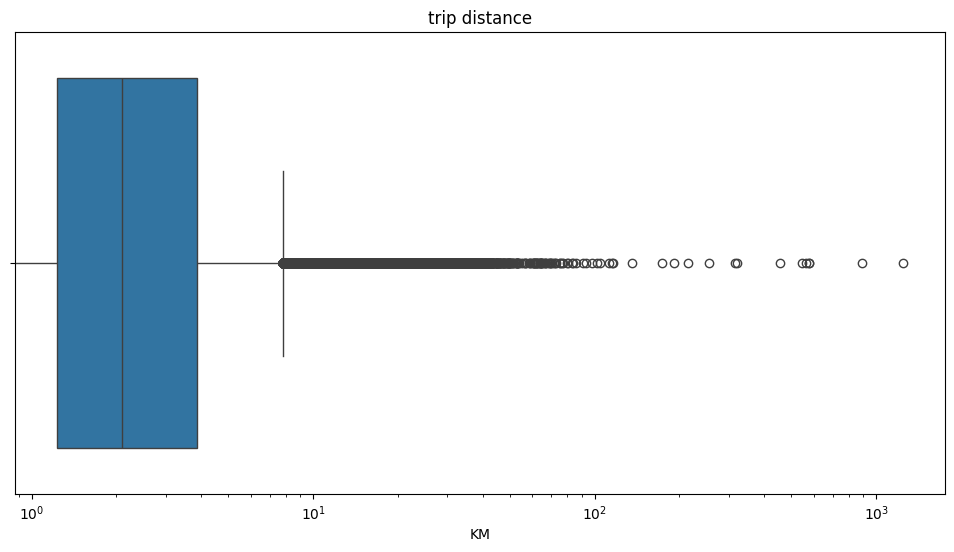

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['distance'])
plt.title('trip distance')
plt.xscale('log')
plt.xlabel('KM')
plt.show()

In [16]:
# in theory the longest distance in newyork is around 70km
# lets assume the shortest trip is only 500 meters
distance_outlier = (df['distance'] > 70) | (df['distance'] < 0.5)
print(f"total outliers in distance: {distance_outlier.sum()}")

total outliers in distance: 48934


## Trip Duration Outliers

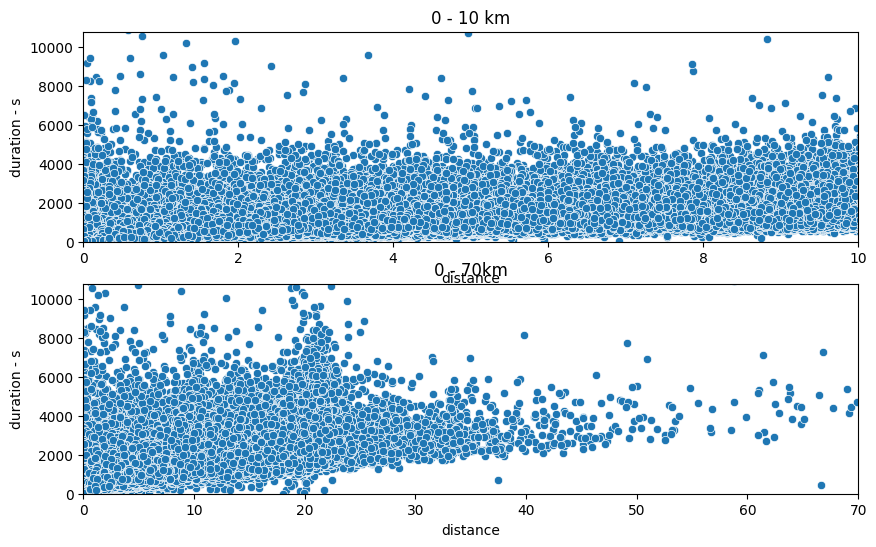

In [17]:
# first five 5km
plt.figure(figsize=(10,6))


plt.subplot(2, 1, 1)
sns.scatterplot(x=df['distance'], y=df['trip_duration'])
plt.ylabel('duration - s')
plt.title('0 - 10 km')
plt.ylim(0, 3*60*60)
plt.xlim(0, 10)


plt.subplot(2, 1, 2)
sns.scatterplot(x=df['distance'], y=df['trip_duration'])
plt.ylabel('duration - s')
plt.title('0 - 70km')
plt.ylim(0, 3*60*60)
plt.xlim(0, 70)


plt.show()

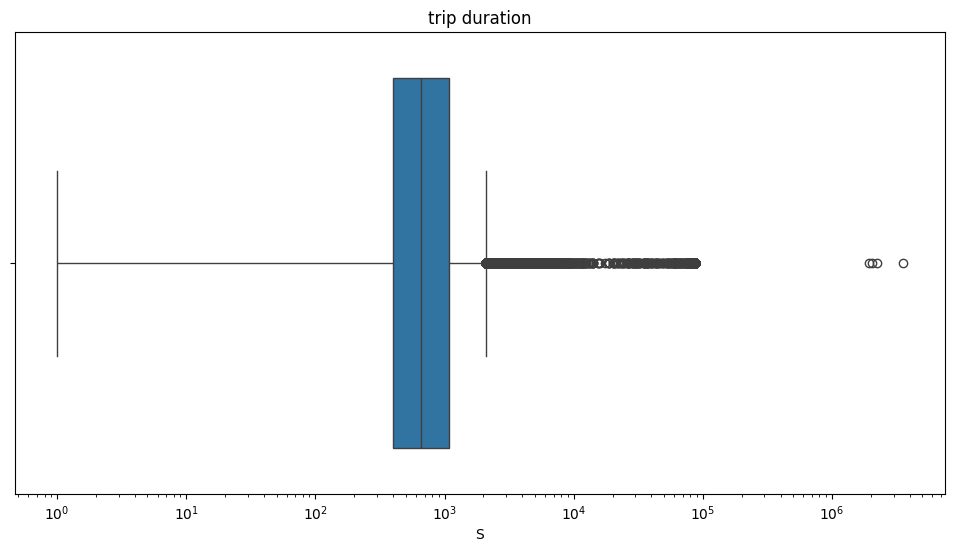

In [18]:
# box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['trip_duration'])
plt.title('trip duration')
plt.xscale('log')
plt.xlabel('S')
plt.show()

In [19]:
# finding the  correct percentile 
# we can take 122 seconds for the lower bound

for percentile in range(0, 11):
    perc = df['trip_duration'].quantile(percentile/100)
    print(f"{percentile} percentile: {perc:.2f} seconds")

0 percentile: 1.00 seconds
1 percentile: 87.00 seconds
2 percentile: 122.00 seconds
3 percentile: 146.00 seconds
4 percentile: 165.00 seconds
5 percentile: 180.00 seconds
6 percentile: 195.00 seconds
7 percentile: 209.00 seconds
8 percentile: 221.00 seconds
9 percentile: 233.00 seconds
10 percentile: 245.00 seconds


In [20]:
# we can take 3440 seconds for the upper bound

for percentile in range(90,  101):
    perc = df['trip_duration'].quantile(percentile/100)
    print(f"{percentile} percentile: {perc:.2f} seconds")

90 percentile: 1634.00 seconds
91 percentile: 1703.00 seconds
92 percentile: 1780.00 seconds
93 percentile: 1869.00 seconds
94 percentile: 1975.00 seconds
95 percentile: 2104.00 seconds
96 percentile: 2273.00 seconds
97 percentile: 2497.00 seconds
98 percentile: 2829.00 seconds
99 percentile: 3440.00 seconds
100 percentile: 3526282.00 seconds


In [21]:
lower = df['trip_duration'].quantile(0.02)
upper = df['trip_duration'].quantile(0.99)

trip_outliers = (df['trip_duration'] < lower) | (df['trip_duration'] > upper)
print(f"total outliers: {trip_outliers.sum()}")

total outliers: 43442


## Passenger Count Outliers

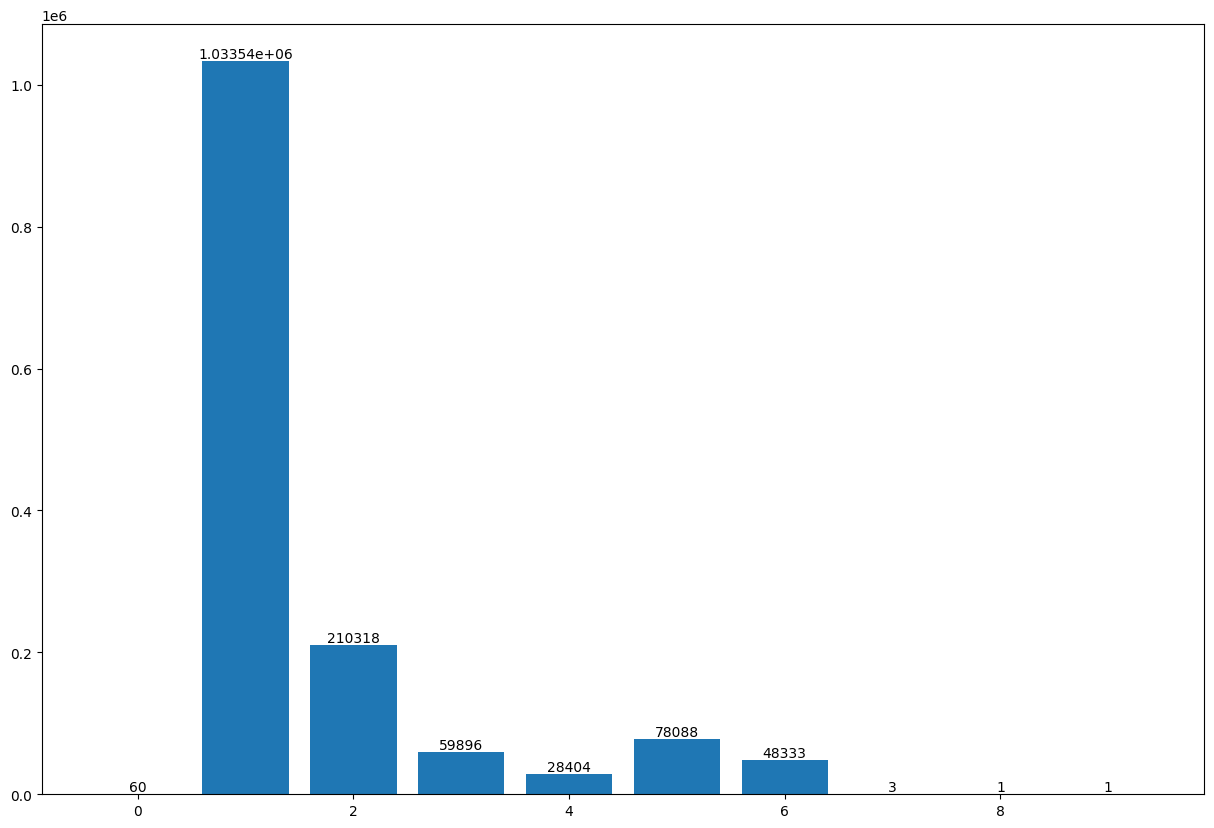

In [22]:
# passenger outlier
plt.figure(figsize=(15, 10))
bars = plt.bar(df['passenger_count'].value_counts().index, df['passenger_count'].value_counts().values)
plt.bar_label(bars)
plt.show()

In [23]:
pass_outliers = ~df['passenger_count'].between(1, 6)

print(f"total outliers: {(pass_outliers).sum()}")

total outliers: 65


## Cleaning

In [24]:
# columns to drop
df = df.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime'])
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'pickup_day', 'pickup_month',
       'distance'],
      dtype='object')

In [25]:
all_outliers = location_outliers | distance_outlier | trip_outliers | pass_outliers
all_outliers.sum()

79264

In [26]:
df_clean = df[~all_outliers].copy()
df_clean.shape

(1379380, 12)

## Data Prepration

In [27]:
df_clean.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'pickup_day', 'pickup_month',
       'distance'],
      dtype='object')

In [28]:
X = df_clean.drop(columns=['trip_duration'])
y = df_clean['trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")

train shape: (1103504, 11)
test shape: (275876, 11)


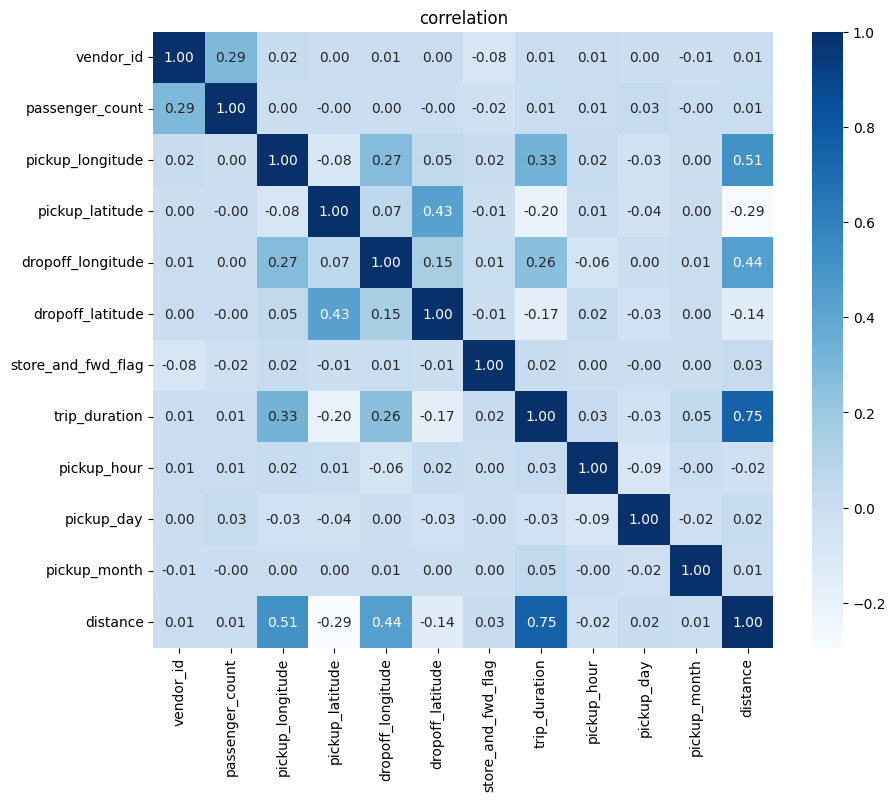

In [29]:
plt.figure(figsize=(10, 8))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('correlation')
plt.show()

## Parameters Tuning

In [31]:
# grid seacrch to find best params
# https://xgboosting.com/objective/
xgb = XGBRegressor(
    objective = 'reg:squaredlogerror',
    n_jobs = -1,
    random_state = 42
)


params = {
    'max_depth' : [5, 9],
    'learning_rate' : [0.1, 0.05],
    'n_estimators': [500, 1000],
    'colsample_bytree' : [0.8, 1.0],
    'subsample' : [0.8, 1.0] 
}


""" grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring='neg_mean_squared_log_error',
    verbose=2
).fit(X_train, y_train) """


# random search is much faster than grid search on a large dataset like this
# but its still slow (using n_iter=5 to make it fast for now!!!!!!!!)
# bayes search might be better 
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=5,
    verbose=2,
    cv=3,
    scoring='neg_root_mean_squared_log_error',
    random_state=42
).fit(X_train, y_train)


best_params = random_search.best_params_
print(f"best parameters: {best_params}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=500, subsample=1.0; total time=  10.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=500, subsample=1.0; total time=   5.7s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=500, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=1000, subsample=1.0; total time=   9.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=1000, subsample=1.0; total time=   9.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=1000, subsample=1.0; total time=   8.9s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time=   5.5s
[CV] END 

In [ ]:
"""params = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(500, 2000),
    'num_leaves': Integer(20, 100), 
    'max_depth': Integer(5, 15),
    'subsample': Real(0.6, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform')
}


bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)


print(f"Best parameters found: {bayes_search.best_params_}") """

' lgb = LGBMRegressor(\n    objective=\'regression_l1\',\n    n_jobs=-1,\n    random_state=42\n)\n\n\nparams = {\n    \'learning_rate\': Real(0.01, 0.3, prior=\'log-uniform\'),\n    \'n_estimators\': Integer(500, 2000),\n    \'num_leaves\': Integer(20, 100), \n    \'max_depth\': Integer(5, 15),\n    \'subsample\': Real(0.6, 1.0, prior=\'uniform\'),\n    \'colsample_bytree\': Real(0.6, 1.0, prior=\'uniform\')\n}\n\n\nbayes_search = BayesSearchCV(\n    estimator=lgb,\n    search_spaces=params,\n    cv=3,\n    scoring=\'neg_root_mean_squared_error\',\n    verbose=2,\n    random_state=42,\n    n_jobs=-1\n).fit(X_train, y_train)\n\n\nprint(f"Best parameters found: {bayes_search.best_params_}") '

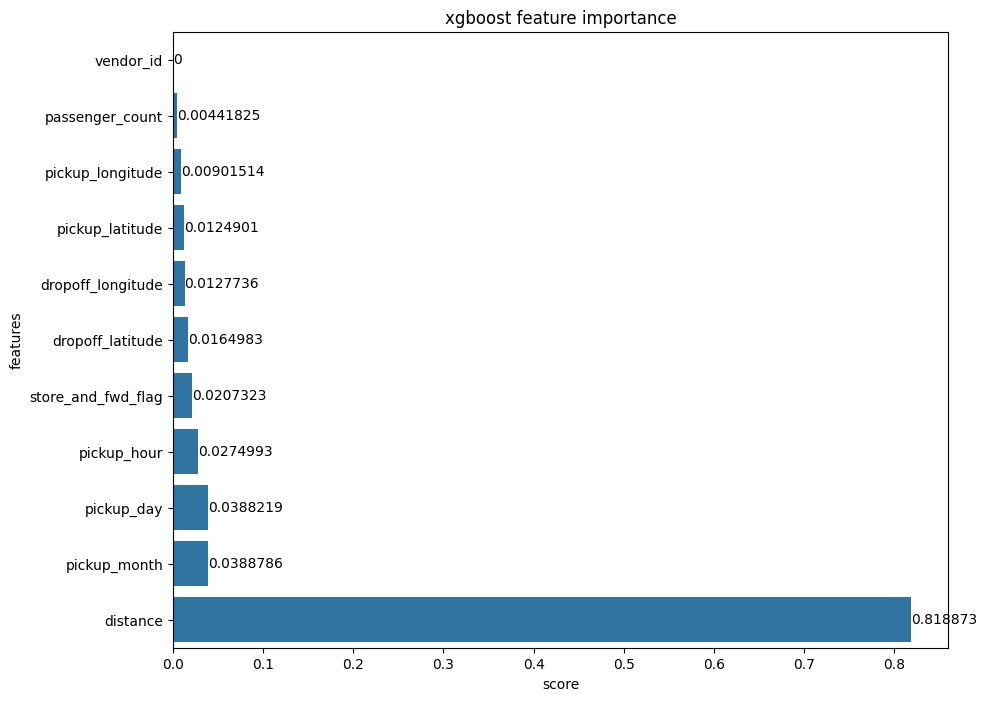

In [32]:
importances = np.sort(random_search.best_estimator_.feature_importances_)
feature_names = X_train.columns


plt.figure(figsize=(10, 8))
ax = sns.barplot(x=importances, y=feature_names)
ax.bar_label(ax.containers[0])
plt.title('xgboost feature importance')
plt.xlabel('score')
plt.ylabel('features')
plt.show()

## Model Training

In [33]:
best_features = df_clean[['distance', 'pickup_month', 'pickup_day', 'pickup_hour',
                         'pickup_latitude', 'pickup_longitude',
                         'dropoff_latitude', 'dropoff_longitude']]

In [34]:
xgb_model = XGBRegressor(
    **best_params,
    random_state=42,
    objective = 'reg:squaredlogerror',
    n_jobs = -1
).fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmsle_xgb = root_mean_squared_log_error(y_test, y_pred)
print(f"RMSLE: {rmsle_xgb}")



# further tuning is needed 
# might find better parameters using bayes search algorithm
# since using random search and grid search on a big data takes a lot of time and resources

RMSLE: 0.4260809123516083
